In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
a1 = np.array([-1,0,0])
a2 = np.array([1/2,np.sqrt(3)/2,0])
a3 = np.array([1/2,-np.sqrt(3)/2,0])
a = np.stack((a1, a2, a3))
d = 1
def mat(i: int,j: int,k: np.ndarray) -> float:
    
    fij = 0 
    for ai in a:
        fnu =0
        if i==j:
            fnu += 3
            if i == 2:
                fnu += 6*d
        fnu -= ai[i] * ai[j]* 15
        fnu *= np.exp(1j* np.dot(ai,k))
        fij += fnu
    return fij

def mat_gradient(i: int,j: int,k: np.ndarray,axis: int) -> float:
    if np.all(k == 0):
        return 0
    fij = 0 
    for ai in a:
        fnu =0
        if i==j:
            fnu += 3
            if i == 2:
                fnu += 6*d
        fnu -= ai[i] * ai[j]* 15
        fnu *= 1j* ai[axis]* np.exp(1j* np.dot(ai,k))
        fij += fnu
    return fij

def D_mat(k: np.ndarray) -> np.ndarray:
    """Calculate the D matrix for the given k vector."""
    dmat= np.zeros((6,6), dtype=complex)
    for i in range(6):
        for j in range(6):
            if i < 3 and j < 3:
               dmat[i, j] = -mat(i, j, np.zeros(3))
            elif i >= 3 and j >= 3:
                dmat[i, j] = dmat[i-3, j-3]
            elif i < 3 and j >= 3:
                dmat[i, j] = mat(i,j-3,k)
            elif i >= 3 and j < 3:
                dmat[i, j] = np.conjugate(mat(i-3,j,k))
    return dmat

def D_mat_gradient(k: np.ndarray) -> np.ndarray:
    """Calculate the D matrix for the given k vector."""
    dmatx= np.zeros((6,6), dtype=complex)
    dmaty = np.zeros((6,6), dtype=complex)
    for i in range(6):
        for j in range(6):
            if i < 3 and j >= 3:
                dmatx[i, j] = mat_gradient(i,j-3,k,0)
                dmaty[i, j] = mat_gradient(i,j-3,k,1)
            elif i >= 3 and j < 3:
                dmatx[i, j] = np.conjugate(mat_gradient(i-3,j,k,0))
                dmaty[i, j] = np.conjugate(mat_gradient(i-3,j,k,1))
    return dmatx, dmaty
# ex = D_mat(np.array([1/2,1/2,0]))  # Example usage to compute D matrix for a specific k vector
# pd.DataFrame(ex, columns=[f'j{i}' for i in range(6)], index=[f'i{i}' for i in range(6)])  # Convert to DataFrame for better visualization
# for i in range(6):
#     for j in range(6):
#         print(f"{ex[i,j]:.2}", end='\t\t')
#     print()  # Print each row of the matrix on a new line


In [ ]:
k1 = np.zeros(3)
b = 4*np.pi/3/np.sqrt(3)
k2 = np.array([0,b,0])
k3 = b*np.array([np.sqrt(3)/4,3/4,0])

def k_course(t: float) -> np.ndarray:
    """Calculate the k vector based on the time parameter t."""
    if t < 1/3:
        return (1-t*3) * k3
    elif t < 2/3:
        return (t-1/3)*3* k2
    else:
        return (t-2/3)*3 * (k3-k2) + k2
    
# fig, ax  = plt.subplots(figsize=(8, 6))
t = np.linspace(0, 1,200)
eigs = np.zeros((len(t), 6,7), dtype=complex)

def sort_eigenvalues(eigenvalues: np.ndarray,eigenvectors: np.ndarray) -> np.ndarray:
    """Sort eigenvalues in ascending order."""
    eigenvectors *= np.conjugate(eigenvectors[0, :])/np.array([np.absolute(eigenvectors[0,i]) for i in range(eigenvectors.shape[1])]) # Normalize the eigenvectors
    comb = np.column_stack((eigenvalues.T, eigenvectors.T))
    # return comb
    sorted_comb = sorted(comb, key=lambda x: x[0])
    return np.array(sorted_comb)

eigs2 = np.zeros((len(t), 6,7), dtype=complex)
for i in range(len(t)):
    k = k_course(t[i])
    dmat = D_mat(k)
    eigvals, eigvecs = np.linalg.eig(dmat)
    eigs[i, :] = sort_eigenvalues(eigvals, eigvecs)
    k_course2 = k2+np.array([1,0,0])*(-1/2+t[i])
    dmat2 = D_mat(k_course2)
    eigvals2, eigvecs2 = np.linalg.eig(dmat2)
    eigs2[i, :] = sort_eigenvalues(eigvals2, eigvecs2)
    # Plot the k vector
    # ax.scatter(k[0], k[1], color='blue', s=10)
    # for eig in eigvals:
    #     ax.scatter(x,eig,color='blue', s=10, alpha=0.5)
# plt.show()
 


In [61]:
eigs[0,:,0]

array([-36.+3.54026066e-16j, -18.+1.42233077e-15j,  -6.-6.96368513e-16j,
         3.-1.59836068e-15j,  24.-4.34479603e-16j,  33.-2.68393366e-16j])

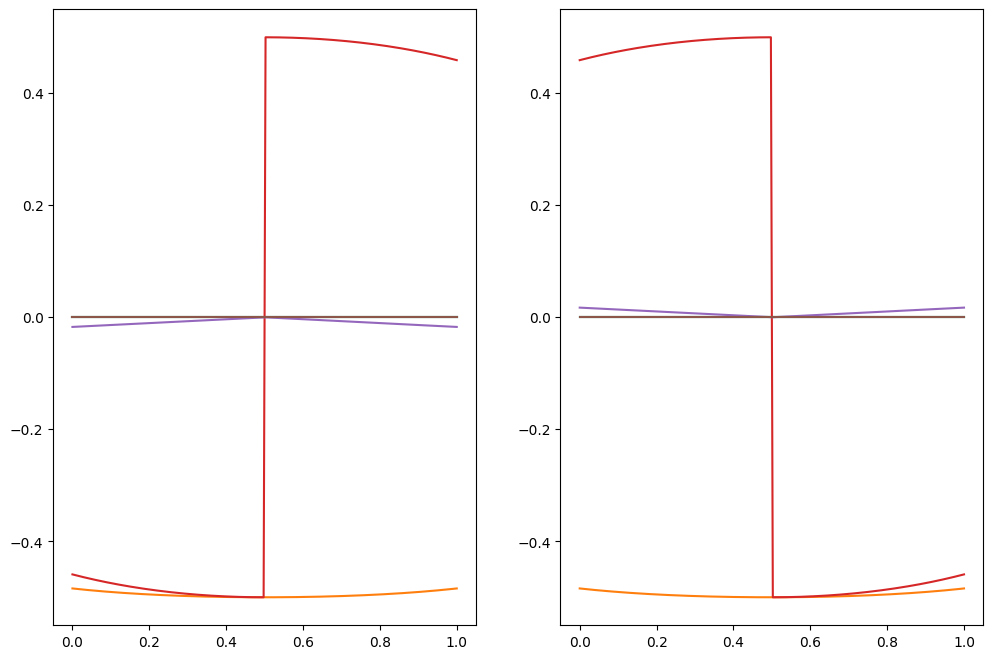

In [109]:
fig, ax = plt.subplots(1,2,figsize=(12, 8))
for i in range(6):
    # ax[0].plot(t, eigs[:, i,0], label=f'Eigenvalue {i+1}')#,color='blue', alpha=0.7)
    ax[1].plot(t, np.imag(eigs2[:, 4,i+1]), label=f'Eigenvalue {i+1}')#,color='blue', alpha=0.7)
    ax[0].plot(t, np.imag(eigs2[:, 3,i+1]), label=f'Eigenvalue {i+1}')#,color='blue', alpha=0.7)
plt.show()


In [ ]:
def Berry_curvature(k,band_index) -> np.ndarray:
    """Calculate the Berry curvature."""
    D_grad = D_mat_gradient(k)
    dmat0 = D_mat(k)
    eigvals0, eigvecs0 = np.linalg.eig(dmat0)
    eigs0 = sort_eigenvalues(eigvals0, eigvecs0)
    berry_curvature = 0
    # for i in range(eigs0.shape[0]):
    for i in range(3,4):
        if i == band_index:
            continue
        berry_curvature += 2*np.imag(np.tensordot(np.tensordot(np.conjugate(eigs0[band_index,1:]),D_grad[0],axes=(0,0)),eigs0[i,1:],axes=(0,0))\
                                     *np.tensordot(np.tensordot(np.conjugate(eigs0[i,1:]),D_grad[1],axes=(0,0)),eigs0[band_index,1:],axes=(0,0)))/(eigs0[band_index,0] - eigs0[i,0])**2
    return berry_curvature

def phase(k_vec,tol, band_index,delta_k) -> np.ndarray:
    """Calculate the phase of the eigenvector."""
    berry_phase = np.zeros(2)
    for i in range(2):
        delta = np.zeros(3)
        delta[i] = tol
        dmat1 = D_mat(k_vec+delta)
        dmat2 = D_mat(k_vec-delta)
        dmat0 = D_mat(k_vec)
        eigvals0, eigvecs0 = np.linalg.eig(dmat0)
        eigs0 = sort_eigenvalues(eigvals0, eigvecs0)
        eigvals1, eigvecs1 = np.linalg.eig(dmat1)
        eigvals2, eigvecs2 = np.linalg.eig(dmat2)
        eigs1 = sort_eigenvalues(eigvals1, eigvecs1)
        eigs2 = sort_eigenvalues(eigvals2, eigvecs2)
        # grad = (eigs1[band_index,1:] - eigs2[band_index,1:]) / (2*tol)
        # berry_phase[i] = -np.imag(np.dot(np.conjugate(eigs0[band_index,1:]), grad))
        berry_phase[i] = np.imag(np.dot(np.conjugate(eigs1[band_index,1:]), eigs0[band_index,1:])-np.dot(np.conjugate(eigs2[band_index,1:]), eigs0[band_index,1:]))/ (2*tol)
    
    berry_phase = berry_phase / np.linalg.norm(berry_phase)*3/4*delta_k
    return berry_phase

grid_size = 19
delta = 0.01
ky_env = np.linspace(b-delta, b+delta, grid_size)
kx_env = np.linspace(-delta, delta, grid_size)
# kx, ky = np.meshgrid(kx_env, ky_env)
# k = np.column_stack((kx, ky, np.zeros_like(kx)))
# eigenvalues = np.zeros((kx.shape[0], kx.shape[1], 6), dtype=complex)
# eigs = np.zeros((kx_env.shape[0], ky_env.shape[0], 6, 7))
phases_for_berry = np.zeros((kx_env.shape[0], kx_env.shape[0], 2))
phases_for_berry2 = np.zeros((kx_env.shape[0], kx_env.shape[0], 2))
B_curvature = np.zeros((kx_env.shape[0], kx_env.shape[0]))
for i in range(kx_env.shape[0]):
    for j in range(ky_env.shape[0]):
        phases_for_berry[i, j] = phase(np.array([kx_env[i],ky_env[j], 0]), 0.001, 4, kx_env[1]-kx_env[0])
        phases_for_berry2[i, j] = phase(np.array([kx_env[i],ky_env[j], 0]), 0.001, 3, kx_env[1]-kx_env[0])
        B_curvature[i, j] = Berry_curvature(np.array([kx_env[i],ky_env[j], 0]), 4)



/tmp/ipykernel_30595/2763962305.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
  B_curvature[i, j] = Berry_curvature(np.array([kx_env[i],ky_env[j], 0]), 4)


In [142]:
def curvature_wrapper(kx,ky):
    """Wrapper function to calculate the curvature."""
    k = np.array([kx, ky, 0])
    return Berry_curvature(k, 4)
from scipy.integrate import dblquad
dblquad(curvature_wrapper, kx_env[0], kx_env[-1], lambda x: ky_env[0], lambda x: ky_env[-1])

/tmp/ipykernel_30595/729845650.py:21: RuntimeWarning: invalid value encountered in divide
  eigenvectors *= np.conjugate(eigenvectors[0, :])/np.array([np.absolute(eigenvectors[0,i]) for i in range(eigenvectors.shape[1])]) # Normalize the eigenvectors
/home/christian/Documents/master/numerics/python_env/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:607: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)
/home/christian/Documents/master/numerics/python_env/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1264: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and cal

KeyboardInterrupt: 

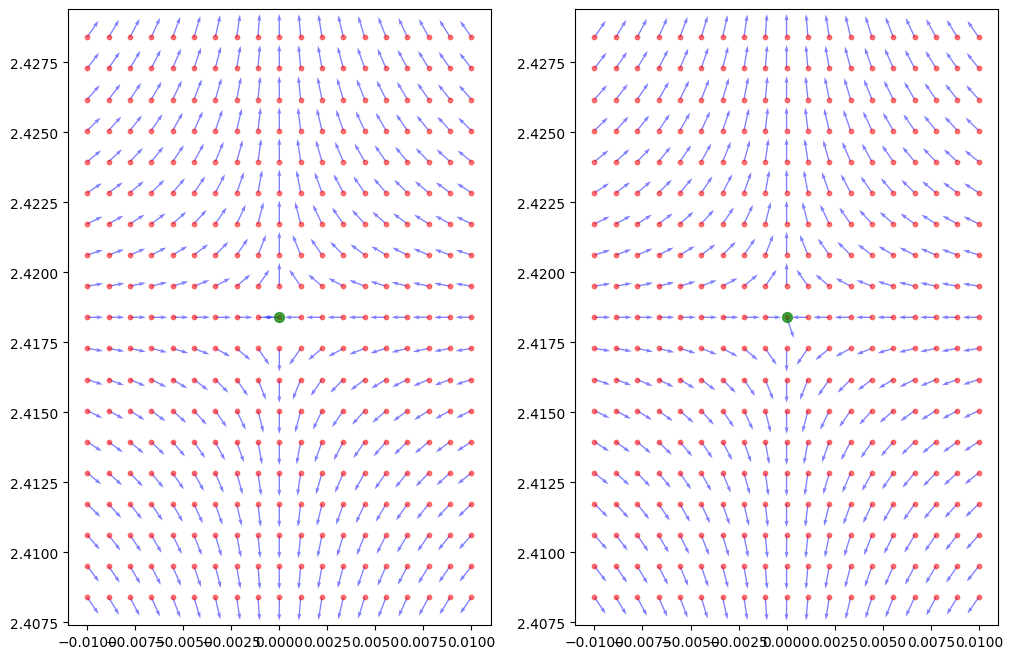

In [171]:
fig, ax = plt.subplots(1,2,figsize=(12, 8))
scale = 1
q = ax[0].quiver(kx_env,ky_env, phases_for_berry[:,:,0]*scale, phases_for_berry[:,:,1]*scale, 
               angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.5)
ax[1].quiver(kx_env,ky_env, phases_for_berry2[:,:,0]*scale, phases_for_berry2[:,:,1]*scale, 
               angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.5)
for i in range(kx_env.shape[0]):
    for j in range(ky_env.shape[0]):
        ax[0].scatter(kx_env[i], ky_env[j], color='red', s=10, alpha=0.5)
        ax[1].scatter(kx_env[i], ky_env[j], color='red', s=10, alpha=0.5)
ax[0].scatter(np.mean(kx_env), np.mean(ky_env), color='green', s=50, label='K point', alpha=0.7)
ax[1].scatter(np.mean(kx_env), np.mean(ky_env), color='green', s=50, label='K point', alpha=0.7)
plt.show()

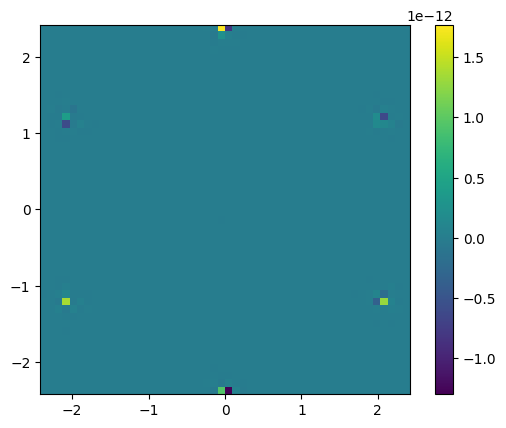

In [149]:
fig, ax = plt.subplots(1,1)
im = ax.imshow(B_curvature.T, extent=(kx_env[0], kx_env[-1], ky_env[0], ky_env[-1]), origin='lower', cmap='viridis')
cbar = plt.colorbar(im, ax=ax)

In [16]:
A = np.array(['a', 'b', 'c'])
B = np.array(['d', 'e', 'f'])
C = np.meshgrid(A, B)
C

(array([['a', 'b', 'c'],
        ['a', 'b', 'c'],
        ['a', 'b', 'c']], dtype='<U1'),
 array([['d', 'd', 'd'],
        ['e', 'e', 'e'],
        ['f', 'f', 'f']], dtype='<U1'))

In [55]:
a = np.arange(4)
# b = np.arange(5,17).reshape(3,4)
# random array
b = np.random.randint(5, 17, size=(3, 4))
c = np.column_stack((a.T, b.T))
d = np.copy(c)
d[0,:] = c[2,:]
d[2,:] = c[0,:]
d, np.array(sorted(d, key=lambda x: x[0]))

(array([[ 2,  7,  8,  8],
        [ 1,  7, 12, 14],
        [ 0, 10, 15, 13],
        [ 3, 13, 12,  5]]),
 array([[ 0, 10, 15, 13],
        [ 1,  7, 12, 14],
        [ 2,  7,  8,  8],
        [ 3, 13, 12,  5]]))